<a href="https://colab.research.google.com/github/gazalpatel/REINFORCE/blob/main/week_3_1_trials_RL_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Best hyperparameter combination model

In [ ]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break
    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 10 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50	Average Reward: 41.90
Episode 100	Average Reward: 107.22
Episode 150	Average Reward: 182.28
Episode 200	Average Reward: 183.70
Episode 250	Average Reward: 173.50
Episode 300	Average Reward: 199.56

Environment solved in 328 episodes with average reward 195.12 over the last 100 episodes.


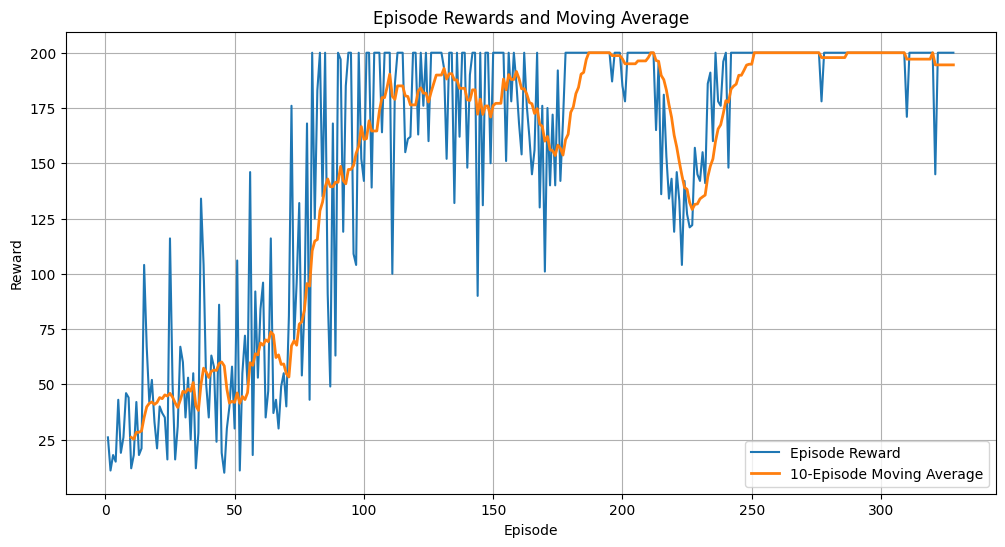

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'episode_rewards' is the list of rewards from training
# Calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot the episode rewards and moving average
plt.figure(figsize=(12,6))
episodes = np.arange(1, len(episode_rewards)+1)
plt.plot(episodes, episode_rewards, label='Episode Reward')

# Choose a window size for moving average (e.g., 10 episodes)
window_size = 10
ma_rewards = moving_average(episode_rewards, window_size)
ma_episodes = episodes[window_size-1:]

plt.plot(ma_episodes, ma_rewards, label=f'{window_size}-Episode Moving Average', linewidth=2)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards and Moving Average')
plt.legend()
plt.grid(True)
plt.show()


# SEED Experiments

In [ ]:
# Install specific versions of libraries (if needed)
# Uncomment and adjust versions if necessary
# !pip install gym==0.21.0
# !pip install torch==1.10.0

# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import os
import sys

# Function to seed everything for reproducibility
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # If using CUDA
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Enforce deterministic algorithms (may impact performance)
    torch.use_deterministic_algorithms(True)
    # Remove or comment out the following line to allow multithreading
    # torch.set_num_threads(1)

# Load configurations from a dictionary or a config file
config = {
    'seed': 20,
    'learning_rate': 0.003,
    'gamma': 0.95,
    'num_episodes': 500,
    'max_steps': 500,
    'hidden_size': 128,
    'environment': 'CartPole-v0'
}

# Set the random seed for reproducibility
seed = config['seed']
seed_everything(seed)

# Create the environment
env = gym.make(config['environment'])
env.seed(seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=config['hidden_size'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net.to(device)

# Set the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=config['learning_rate'])

# Training parameters
gamma = config['gamma']
num_episodes = config['num_episodes']
max_steps = config['max_steps']

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    # Reset environment with a seed
    state = env.reset(seed=seed + episode)
    state = torch.from_numpy(state).float().to(device)
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float().to(device)
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break
    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns).to(device)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()

# Print library versions for reference
print('Python version:', sys.version)
print('NumPy version:', np.__version__)
print('PyTorch version:', torch.__version__)
print('Gym version:', gym.__version__)


## testing hyperparameter model


Average score over 100 test episodes: 200.00
Number of Successes: 100
Number of Failures: 0


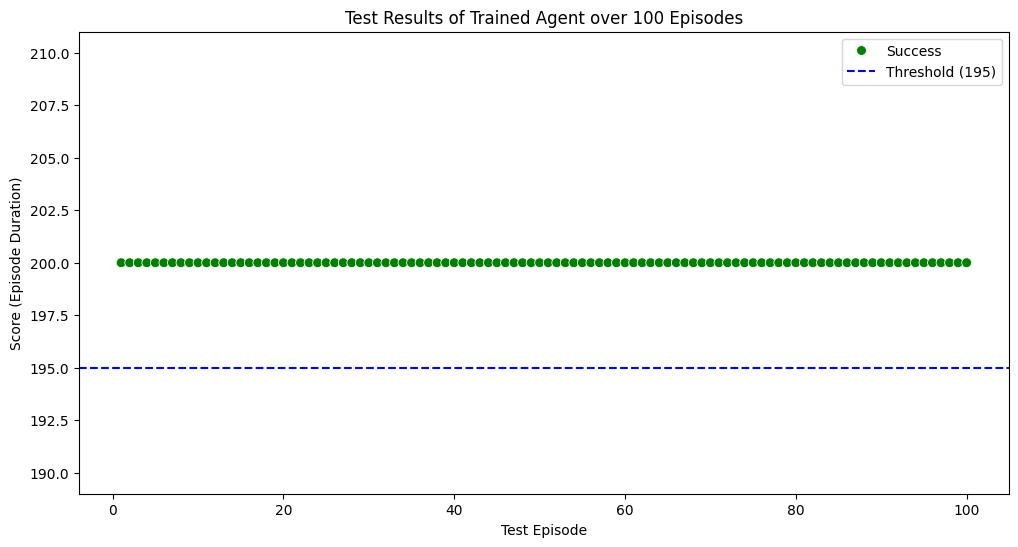

In [ ]:
# Testing the trained agent over 100 episodes
def test_agent(env, policy_net, max_steps=200):
    state = env.reset()
    state = torch.from_numpy(state).float()
    total_reward = 0
    done = False
    for _ in range(max_steps):
        with torch.no_grad():
            # Get action probabilities from the policy network
            probs = policy_net(state)
            # Select the action with the highest probability
            action = torch.argmax(probs).item()
            # Step the environment
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
            # Update state
            state = torch.from_numpy(next_state).float()
    return total_reward

# Run the test over 100 episodes
test_episodes = 100
test_scores = []
for episode in range(test_episodes):
    score = test_agent(env, policy_net, max_steps=200)
    test_scores.append(score)

# Compute average score
average_score = np.mean(test_scores)
print(f'\nAverage score over {test_episodes} test episodes: {average_score:.2f}')

# Determine successes and failures
success_threshold = 195  # For CartPole-v0
test_results = ['Success' if score >= success_threshold else 'Failure' for score in test_scores]

# Print number of successes and failures
num_successes = test_results.count('Success')
num_failures = test_results.count('Failure')
print(f'Number of Successes: {num_successes}')
print(f'Number of Failures: {num_failures}')

# Create a DataFrame for plotting
import pandas as pd
test_df = pd.DataFrame({'Episode': range(1, test_episodes + 1), 'Score': test_scores, 'Result': test_results})

# Plotting the test results as a scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.scatterplot(data=test_df, x='Episode', y='Score', hue='Result', palette={'Success': 'green', 'Failure': 'red'}, s=50)
plt.axhline(y=success_threshold, color='blue', linestyle='--', label=f'Threshold ({success_threshold})')
plt.xlabel('Test Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Test Results of Trained Agent over 100 Episodes')
plt.legend()
plt.show()


# 2. Baseline Model

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50	Average Reward: 38.46
Episode 100	Average Reward: 86.20
Episode 150	Average Reward: 173.72
Episode 200	Average Reward: 154.92
Episode 250	Average Reward: 198.08

Environment solved in 275 episodes with average reward 195.18 over the last 100 episodes.


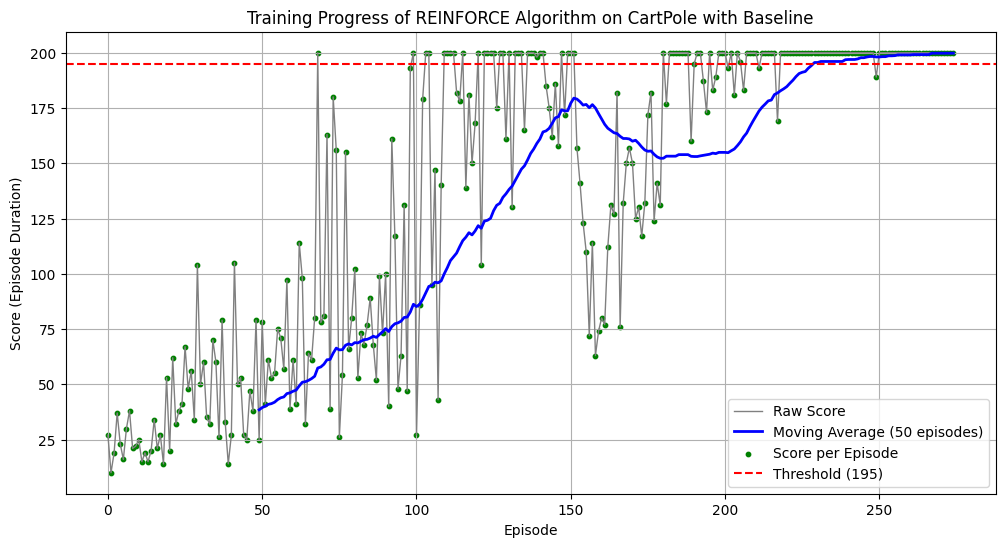

In [ ]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break
    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Compute the baseline (mean of returns)
    baseline = returns.mean()
    # Compute advantages by subtracting the baseline
    advantages = returns - baseline
    # Normalize advantages for better convergence
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)
    # Compute policy gradient loss using advantages
    loss = []
    for log_prob, advantage in zip(log_probs, advantages):
        loss.append(-log_prob * advantage)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()

# Plotting the rewards vs episodes
import matplotlib.pyplot as plt

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of REINFORCE Algorithm on CartPole with Baseline')
plt.legend()
plt.grid(True)
plt.show()


## testing baseline


Average score over 100 test episodes: 200.00
Number of Successes: 100
Number of Failures: 0


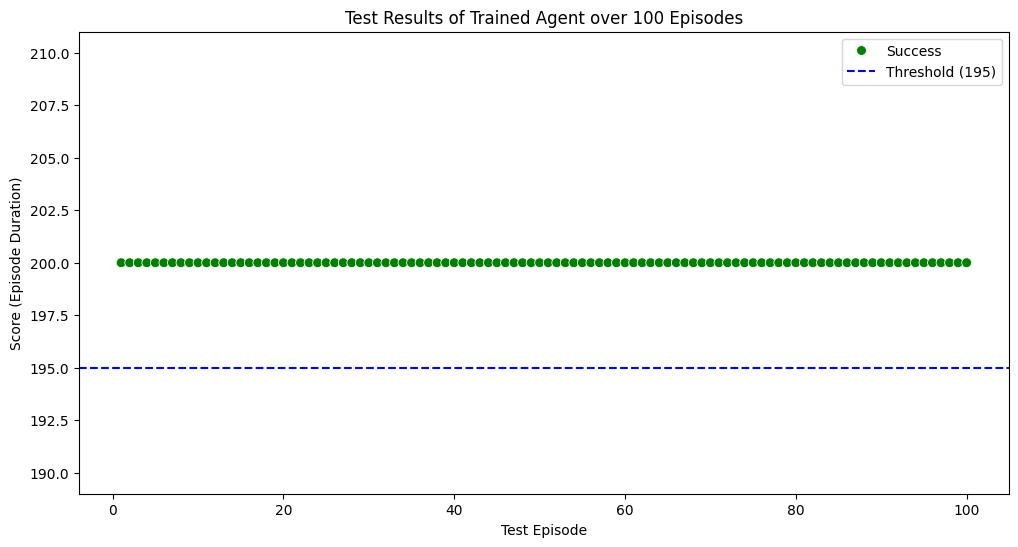

In [ ]:
# Testing the trained agent over 100 episodes
def test_agent(env, policy_net, max_steps=200):
    state = env.reset()
    state = torch.from_numpy(state).float()
    total_reward = 0
    done = False
    for _ in range(max_steps):
        with torch.no_grad():
            # Get action probabilities from the policy network
            probs = policy_net(state)
            # Select the action with the highest probability
            action = torch.argmax(probs).item()
            # Step the environment
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
            # Update state
            state = torch.from_numpy(next_state).float()
    return total_reward

# Run the test over 100 episodes
test_episodes = 100
test_scores = []
for episode in range(test_episodes):
    score = test_agent(env, policy_net, max_steps=200)
    test_scores.append(score)

# Compute average score
average_score = np.mean(test_scores)
print(f'\nAverage score over {test_episodes} test episodes: {average_score:.2f}')

# Determine successes and failures
success_threshold = 195  # For CartPole-v0
test_results = ['Success' if score >= success_threshold else 'Failure' for score in test_scores]

# Print number of successes and failures
num_successes = test_results.count('Success')
num_failures = test_results.count('Failure')
print(f'Number of Successes: {num_successes}')
print(f'Number of Failures: {num_failures}')

# Create a DataFrame for plotting
import pandas as pd
test_df = pd.DataFrame({'Episode': range(1, test_episodes + 1), 'Score': test_scores, 'Result': test_results})

# Plotting the test results as a scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.scatterplot(data=test_df, x='Episode', y='Score', hue='Result', palette={'Success': 'green', 'Failure': 'red'}, s=50)
plt.axhline(y=success_threshold, color='blue', linestyle='--', label=f'Threshold ({success_threshold})')
plt.xlabel('Test Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Test Results of Trained Agent over 100 Episodes')
plt.legend()
plt.show()


# 3. CUSTOM REWARD

### testing

# 4. Entropy Regularization with Baseline

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50	Average Reward: 36.08
Episode 100	Average Reward: 89.12
Episode 150	Average Reward: 161.48
Episode 200	Average Reward: 176.32
Episode 250	Average Reward: 113.96
Episode 300	Average Reward: 190.54
Episode 350	Average Reward: 151.72
Episode 400	Average Reward: 195.94

Environment solved in 447 episodes with average reward 195.06 over the last 100 episodes.


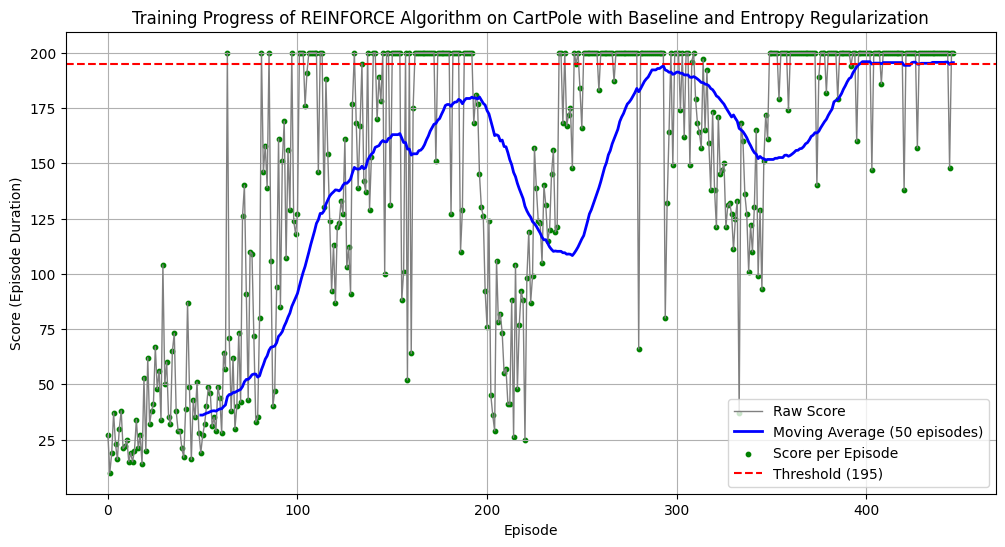

In [ ]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        # Note: We'll apply softmax in the forward pass to get probabilities

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)
        probs = torch.softmax(logits, dim=-1)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
policy_optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500
entropy_coef = 0.01  # Entropy regularization coefficient

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []
    probs_list = []  # To store action probabilities for entropy calculation

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float()
        # Save reward, log probability, and probabilities
        rewards.append(reward)
        log_probs.append(log_prob)
        probs_list.append(probs)
        # Update state
        state = next_state
        if done:
            break
    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32)
    # Compute the baseline (mean of returns)
    baseline = returns.mean()
    # Compute advantages by subtracting the baseline
    advantages = returns - baseline
    # Normalize advantages for better convergence
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)
    # Compute policy gradient loss using advantages and entropy regularization
    policy_loss = []
    for log_prob, advantage, prob in zip(log_probs, advantages, probs_list):
        entropy = -torch.sum(prob * torch.log(prob + 1e-9))
        policy_loss.append(-log_prob * advantage - entropy_coef * entropy)
    policy_loss = torch.stack(policy_loss).sum()
    # Update policy network
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()

# Plotting the rewards vs episodes
import matplotlib.pyplot as plt

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
if len(score_array) >= window_size:
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of REINFORCE Algorithm on CartPole with Baseline and Entropy Regularization')
plt.legend()
plt.grid(True)
plt.show()


## testing entropy regularization with baseline


Average score over 100 test episodes: 200.00
Number of Successes: 100
Number of Failures: 0


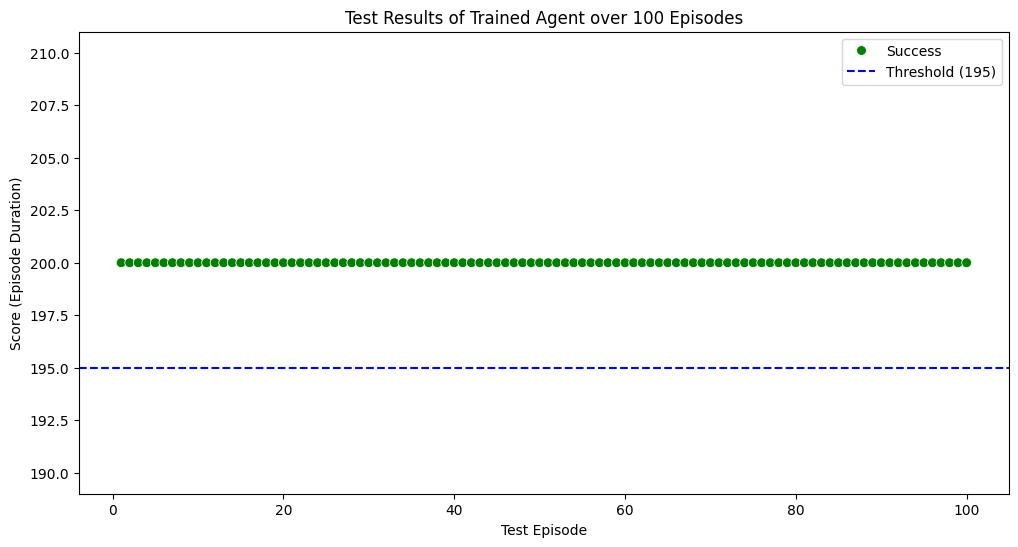

In [ ]:
# Testing the trained agent over 100 episodes
def test_agent(env, policy_net, max_steps=200):
    state = env.reset()
    state = torch.from_numpy(state).float()
    total_reward = 0
    done = False
    for _ in range(max_steps):
        with torch.no_grad():
            # Get action probabilities from the policy network
            probs = policy_net(state)
            # Select the action with the highest probability
            action = torch.argmax(probs).item()
            # Step the environment
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
            # Update state
            state = torch.from_numpy(next_state).float()
    return total_reward

# Run the test over 100 episodes
test_episodes = 100
test_scores = []
for episode in range(test_episodes):
    score = test_agent(env, policy_net, max_steps=200)
    test_scores.append(score)

# Compute average score
average_score = np.mean(test_scores)
print(f'\nAverage score over {test_episodes} test episodes: {average_score:.2f}')

# Determine successes and failures
success_threshold = 195  # For CartPole-v0
test_results = ['Success' if score >= success_threshold else 'Failure' for score in test_scores]

# Print number of successes and failures
num_successes = test_results.count('Success')
num_failures = test_results.count('Failure')
print(f'Number of Successes: {num_successes}')
print(f'Number of Failures: {num_failures}')

# Create a DataFrame for plotting
import pandas as pd
test_df = pd.DataFrame({'Episode': range(1, test_episodes + 1), 'Score': test_scores, 'Result': test_results})

# Plotting the test results as a scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.scatterplot(data=test_df, x='Episode', y='Score', hue='Result', palette={'Success': 'green', 'Failure': 'red'}, s=50)
plt.axhline(y=success_threshold, color='blue', linestyle='--', label=f'Threshold ({success_threshold})')
plt.xlabel('Test Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Test Results of Trained Agent over 100 Episodes')
plt.legend()
plt.show()


Episode 50	Average Reward (Last 50): 23.48	Epsilon: 0.56
Episode 100	Average Reward (Last 50): 22.54	Epsilon: 0.32
Episode 150	Average Reward (Last 50): 24.44	Epsilon: 0.18
Episode 200	Average Reward (Last 50): 37.02	Epsilon: 0.08
Episode 250	Average Reward (Last 50): 100.36	Epsilon: 0.02
Episode 300	Average Reward (Last 50): 164.76	Epsilon: 0.01
Episode 350	Average Reward (Last 50): 96.32	Epsilon: 0.01
Episode 400	Average Reward (Last 50): 130.96	Epsilon: 0.01
Episode 450	Average Reward (Last 50): 121.26	Epsilon: 0.01
Episode 500	Average Reward (Last 50): 94.38	Epsilon: 0.01


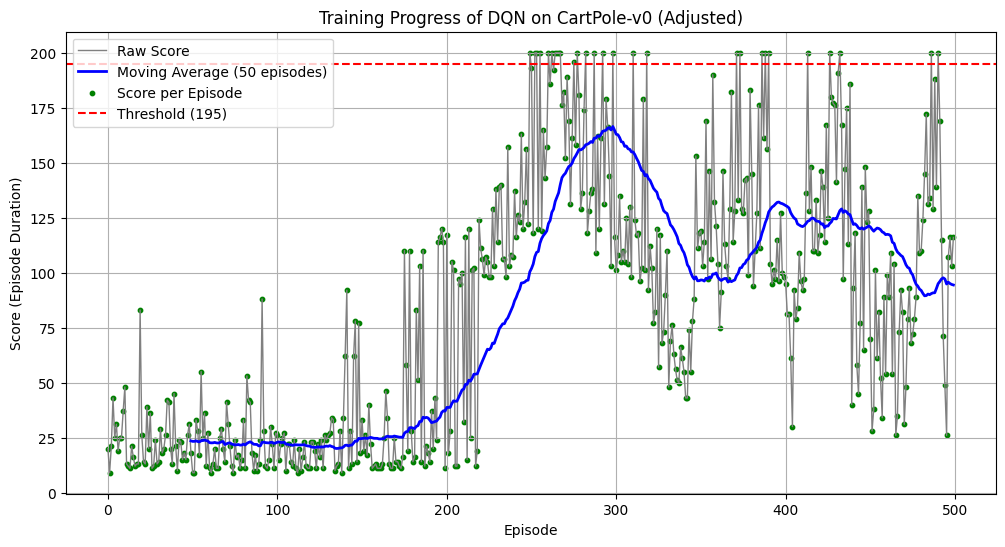

In [ ]:
# Training code for DQN on CartPole-v0

# Import necessary libraries
import numpy as np
import random
from collections import deque
import gym
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seeds for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Implement state normalizer
class Normalizer:
    def __init__(self, n_inputs):
        self.n = 0
        self.mean = np.zeros(n_inputs)
        self.var = np.zeros(n_inputs)

    def observe(self, x):
        self.n += 1
        last_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.n
        self.var += (x - last_mean) * (x - self.mean)

    def normalize(self, x):
        if self.n > 1:
            std = np.sqrt(self.var / (self.n - 1) + 1e-8)
            return (x - self.mean) / std
        else:
            return x

# Instantiate the normalizer
state_normalizer = Normalizer(state_dim)

# Define the updated Q-network with increased complexity
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, action_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        q_values = self.fc4(x)
        return q_values

# Instantiate the Q-network and target network
q_net = QNetwork(state_dim, action_dim)
target_net = QNetwork(state_dim, action_dim)
target_net.load_state_dict(q_net.state_dict())

# Set the optimizer with reduced learning rate
learning_rate = 0.0005
optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)

# Hyperparameters
gamma = 0.99                # Discount factor
epsilon_start = 1.0         # Starting epsilon
epsilon_end = 0.01          # Minimum epsilon
epsilon_decay = 2000        # Slower decay rate
target_update_freq = 1000   # Update target network less frequently
batch_size = 64
memory_size = 50000         # Increased replay memory size
num_episodes = 500

# Replay memory
replay_memory = deque(maxlen=memory_size)

# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randrange(action_dim)
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = q_net(state_tensor)
            return q_values.argmax().item()

# Epsilon decay function
def get_epsilon(step):
    return epsilon_end + (epsilon_start - epsilon_end) * \
           np.exp(-1. * step / epsilon_decay)

# Training loop
episode_rewards = []
total_steps = 0

for episode in range(1, num_episodes + 1):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Normalize state
        state_normalizer.observe(state)
        state_norm = state_normalizer.normalize(state)

        # Select action
        epsilon = get_epsilon(total_steps)
        action = select_action(state_norm, epsilon)

        # Take action in the environment
        next_state, reward, done, _ = env.step(action)

        # Normalize next state
        state_normalizer.observe(next_state)
        next_state_norm = state_normalizer.normalize(next_state)

        # Store transition
        replay_memory.append((state_norm, action, reward, next_state_norm, done))

        state = next_state
        total_reward += reward
        total_steps += 1

        # Experience replay and model training
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*minibatch)

            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            # Compute current Q-values
            q_values = q_net(states).gather(1, actions)

            # Compute next Q-values using target network
            next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)

            # Compute target Q-values
            targets = rewards + gamma * next_q_values * (1 - dones)

            # Compute loss
            loss = nn.functional.mse_loss(q_values, targets)

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the target network
        if total_steps % target_update_freq == 0:
            target_net.load_state_dict(q_net.state_dict())

    episode_rewards.append(total_reward)

    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward (Last 50): {avg_reward:.2f}\t'
              f'Epsilon: {epsilon:.2f}')

    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average '
                  f'reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()

# Plotting the rewards vs episodes
import matplotlib.pyplot as plt

# Convert 'episode_rewards' to a NumPy array
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array,
                             np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
if len(score_array) >= window_size:
    plt.plot(range(window_size - 1, len(score_array)), moving_avg,
             color='blue', linewidth=2,
             label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10,
            label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of DQN on CartPole-v0 (Adjusted)')
plt.legend()
plt.grid(True)
plt.show()
